In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt

In [3]:
from IPython.display import display

In [4]:
pd.set_option('display.max_rows', None)  # Set to None to show all rows
pd.set_option('display.max_columns', None)  # Set to None to show all columns

In [5]:
# Optionally, reset the display options after viewing
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [6]:
circuits = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\circuits.csv')
constructor_results = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\constructor_results.csv')
constructor_standings = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\constructor_standings.csv')
constructors = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\constructors.csv')
driver_standings = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\driver_standings.csv')
drivers = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\drivers.csv')
lap_times = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\lap_times.csv')
pit_stops = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\pit_stops.csv')
qualifying = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\qualifying.csv')
races = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\races.csv')
results = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\results.csv')
seasons = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\seasons.csv')
sprint_results = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\sprint_results.csv')
status = pd.read_csv(r'C:\Users\SAGAVERM\Desktop\DA projects\F1\status.csv')

In [7]:
display(circuits.head())
display(constructor_results.head())
display(constructor_standings.head())
display(constructors.head())
display(driver_standings.head())
display(drivers.head())
display(lap_times.head())
display(pit_stops.head())
display(qualifying.head())
display(races.head())
display(results.head())
display(seasons.head())
display(sprint_results.head())
display(status.head())

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


,constructorResultsId,raceId,constructorId,points,status
0,1,18,1,14.0,\N
1,2,18,2,8.0,\N
2,3,18,3,9.0,\N
3,4,18,4,5.0,\N
4,5,18,5,2.0,\N


,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
0,1,18,1,14.0,1,1,1
1,2,18,2,8.0,3,3,0
2,3,18,3,9.0,2,2,0
3,4,18,4,5.0,4,4,0
4,5,18,5,2.0,5,5,0


,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


,year,url
0,2009,http://en.wikipedia.org/wiki/2009_Formula_One_...
1,2008,http://en.wikipedia.org/wiki/2008_Formula_One_...
2,2007,http://en.wikipedia.org/wiki/2007_Formula_One_...
3,2006,http://en.wikipedia.org/wiki/2006_Formula_One_...
4,2005,http://en.wikipedia.org/wiki/2005_Formula_One_...


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId
0,1,1061,830,9,33,2,1,1,1,3,17,25:38.426,1538426,14,1:30.013,1
1,2,1061,1,131,44,1,2,2,2,2,17,+1.430,1539856,17,1:29.937,1
2,3,1061,822,131,77,3,3,3,3,1,17,+7.502,1545928,17,1:29.958,1
3,4,1061,844,6,16,4,4,4,4,0,17,+11.278,1549704,16,1:30.163,1
4,5,1061,846,1,4,6,5,5,5,0,17,+24.111,1562537,16,1:30.566,1


,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine


In [8]:
from sqlalchemy import MetaData, create_engine, Column, Integer, String, Float, ForeignKey
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker, relationship
from sqlalchemy import text

In [9]:
metadata =MetaData()

In [10]:
# Define the SQLite database
engine = create_engine('sqlite:///f1_data.db')
Base = declarative_base()

In [42]:
# pushing dataframe into sql tables
circuits.to_sql('circuits', engine, index= False, if_exists= 'replace')
drivers.to_sql('drivers', engine, index= False, if_exists= 'replace')
driver_standings.to_sql('driver_standings', engine, index= False, if_exists= 'replace')
constructor_results.to_sql('constructor_results', engine, index= False, if_exists= 'replace')
constructor_standings.to_sql('constructor_standings', engine, index= False, if_exists= 'replace')
constructors.to_sql('constructors', engine, index= False, if_exists= 'replace')
races.to_sql('races', engine, index= False, if_exists= 'replace')
lap_times.to_sql('lap_times', engine, index= False, if_exists= 'replace')
pit_stops.to_sql('pit_stops', engine, index= False, if_exists= 'replace')
qualifying.to_sql('qualifying', engine, index = False, if_exists= 'replace')
status.to_sql('status', engine, index = False, if_exists= 'replace')
results.to_sql('results', engine, index = False, if_exists= 'replace')
sprint_results.to_sql('sprint_results', engine, index = False, if_exists= 'replace')
seasons.to_sql('seasons', engine, index = False, if_exists= 'replace')

75

#### **Circuits Distribution and Occurence**

In [ ]:
#renaming column in races table
with engine.connect() as connection:
    connection.execute(text("""ALTER TABLE races
                               RENAME COLUMN name TO Grand_Prix
                            """))

In [96]:
#query to find distinct circuits name and grand prix name and returing it into Circuit_df dataframe.
query = """
        SELECT DISTINCT circuits.name, circuits.country, 
        FIRST_VALUE(races.Grand_Prix) OVER (PARTITION BY circuits.circuitId ORDER BY races.year) AS grand_prix, 
        circuits.lat, circuits.lng, COUNT(races.year) as occurence
        FROM circuits
        JOIN races ON circuits.circuitId = races.circuitId
        GROUP BY circuits.name, circuits.country
        """
Circuit_df = pd.read_sql(query, engine)

In [97]:
Circuit_df.sort_values(by= 'occurence', ascending= False, inplace= True)
Circuit_df

,name,country,grand_prix,lat,lng,occurence
13,Autodromo Nazionale di Monza,Italy,Italian Grand Prix,45.6156,9.28111,74
5,Circuit de Monaco,Monaco,Monaco Grand Prix,43.7347,7.42056,70
8,Silverstone Circuit,UK,British Grand Prix,52.0786,-1.01694,59
12,Circuit de Spa-Francorchamps,Belgium,Belgian Grand Prix,50.4372,5.97139,57
6,Circuit Gilles Villeneuve,Canada,Canadian Grand Prix,45.5000,-73.52280,43
...,...,...,...,...,...,...
55,Zeltweg,Austria,Austrian Grand Prix,47.2039,14.74780,1
62,Ain Diab,Morocco,Moroccan Grand Prix,33.5786,-7.68750,1
61,Sebring International Raceway,USA,United States Grand Prix,27.4547,-81.34830,1
63,Pescara Circuit,Italy,Pescara Grand Prix,42.4750,14.15080,1


In [98]:
fig = px.scatter_geo(data_frame= Circuit_df, lat= 'lat', lon= 'lng', hover_name= 'name',
                     hover_data= {'occurence': True, 'grand_prix': True},
                     projection= 'natural earth',
                     color= 'country')
fig.update_traces(marker = dict(line= dict(width= 0.5, color= 'black')),
                  hovertemplate= "<b>%{hovertext}<b><br>"+
                                 "<b>%{customdata[1]}<b><br>"+
                                 "occurence:  %{customdata[0]:,.0f}<br>"
                    )
fig.show()

#### **Driver Performance**

In [67]:
#driver performance 
query = """
        SELECT drivers.forename, drivers.surname, COUNT(results.position) AS wins
        FROM drivers
        JOIN results ON drivers.driverId = results.driverId
        WHERE results.position = 1
        GROUP BY drivers.driverId
        ORDER BY wins DESC
        """
driver_performance = pd.read_sql(query, engine)
driver_performance

,forename,surname,wins
0,Lewis,Hamilton,104
1,Michael,Schumacher,91
2,Max,Verstappen,61
3,Sebastian,Vettel,53
4,Alain,Prost,51
...,...,...,...
109,Jean,Alesi,1
110,Olivier,Panis,1
111,Jarno,Trulli,1
112,Robert,Kubica,1


In [103]:
driver_performance['Full Name'] = driver_performance['forename']+" "+driver_performance['surname']

In [115]:
# to drop unnecessary columns
# driver_performance.drop(columns= [['forename', 'surname']], axis =1, inplace= True)

In [116]:
driver_performance.head()

,Full Name,wins
0,Lewis Hamilton,104
1,Michael Schumacher,91
2,Max Verstappen,61
3,Sebastian Vettel,53
4,Alain Prost,51


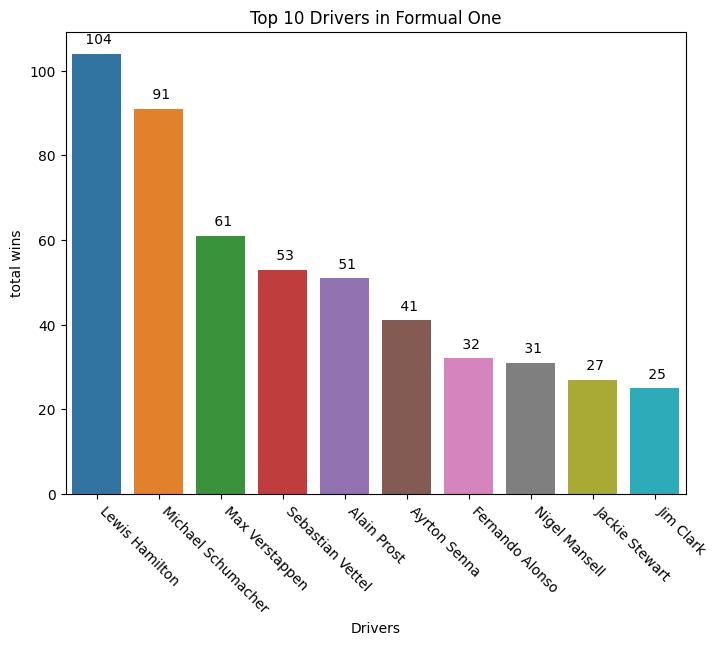

In [139]:
plt.figure(figsize= (8,6))
ax = sns.barplot(data= driver_performance.head(10), x= 'Full Name',y= 'wins', hue= 'Full Name')
plt.title('Top 10 Drivers in Formual One')
plt.ylabel('total wins')
plt.xlabel('Drivers')
plt.xticks(rotation = -45, ha= 'left',va= 'top')
for p in ax.patches:
    ax.annotate(f'{p.get_height(): .0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='bottom', 
                xytext=(0, 5),  # Offset to move text 5 points above the bar
                textcoords='offset points')
plt.show()

#### **Constructor Performance**

In [151]:
query = """
        SELECT constructors.name, COUNT(constructor_standings.position) as wins 
        FROM constructors
        JOIN constructor_standings ON constructors.constructorId = constructor_standings.constructorId
        JOIN races ON races.raceId = constructor_standings.raceId
        WHERE (constructor_standings.position) = 1
        GROUP BY constructors.constructorId
        ORDER BY wins DESC
"""
constructor_performance = pd.read_sql(query, engine)
constructor_performance

,name,wins
0,Ferrari,234
1,McLaren,165
2,Mercedes,145
3,Red Bull,120
4,Williams,114
5,Renault,46
6,Team Lotus,44
7,Benetton,29
8,Lotus-Climax,23
9,Cooper-Climax,20


In [152]:
query= """
        SELECT constructors.name, races.year, COUNT(results.position) AS wins
FROM results
JOIN constructors ON results.constructorId = constructors.constructorId
JOIN races ON results.raceId = races.raceId
WHERE results.position = 1
GROUP BY constructors.constructorId, races.year
ORDER BY wins DESC;
        """
const = pd.read_sql(query, engine)

In [153]:
const

,name,year,wins
0,Red Bull,2023,21
1,Mercedes,2016,19
2,Red Bull,2022,17
3,Mercedes,2014,16
4,Mercedes,2015,16
...,...,...,...
272,Lotus F1,2012,1
273,Lotus F1,2013,1
274,Racing Point,2020,1
275,AlphaTauri,2020,1


In [158]:
print("Constructor standings points stats:\n", constructor_results['points'].describe())
print("Results points stats:\n", results['points'].describe())

Constructor standings points stats:
 count    12505.000000
mean         3.986166
std          7.759519
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max         66.000000
Name: points, dtype: float64
Results points stats:
 count    26519.000000
mean         1.959578
std          4.306475
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         50.000000
Name: points, dtype: float64
